# Method 9 - Best Ideas Low Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] > qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

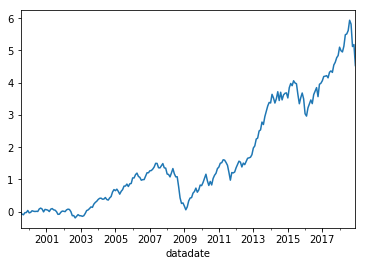

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.037748
2000-12-31    0.030393
2001-12-31   -0.047458
2002-12-31   -0.140528
2003-12-31    0.510801
2004-12-31    0.273621
2005-12-31    0.112779
2006-12-31    0.177108
2007-12-31    0.065150
2008-12-31   -0.459119
2009-12-31    0.435615
2010-12-31    0.279991
2011-12-31   -0.045382
2012-12-31    0.240948
2013-12-31    0.585513
2014-12-31    0.067745
2015-12-31   -0.040296
2016-12-31    0.108163
2017-12-31    0.172482
2018-12-31   -0.053158
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     365.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.82e-98
Time:                        20:55:00   Log-Likelihood:                 596.14
No. Observations:                 234   AIC:                            -1182.
Df Residuals:                     229   BIC:                            -1165.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.504      0.134      -0.001       0.005
mktrf          1.0960      0.036     30.697      0.000       1.026       1.166
me             0.3010      0.042      7.248      0.000       0.219       0.383
ia             0.3342      0.063      5.295      0.000       0.210       0.459
roe            0.1356      0.054      2.509      0.013       0.029       0.242
==============================================================================
Omnibus:                        7.360   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                9.073
Skew:                          -0.252   Prob(JB):                       0.0107
Kurtosis:                       3.823   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     752.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.91e-130
Time:                        20:55:00   Log-Likelihood:                 596.14
No. Observations:                 234   AIC:                            -1182.
Df Residuals:                     229   BIC:                            -1165.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.632      0.103      -0.000       0.004
mktrf          1.0960      0.045     24.343      0.000       1.008       1.184
me             0.3010      0.114      2.636      0.008       0.077       0.525
ia             0.3342      0.124      2.705      0.007       0.092       0.576
roe            0.1356      0.064      2.111      0.035       0.010       0.261
==============================================================================
Omnibus:                        7.360   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                9.073
Skew:                          -0.252   Prob(JB):                       0.0107
Kurtosis:                       3.823   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1061.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.78e-146
Time:                        20:55:00   Log-Likelihood:                 596.14
No. Observations:                 234   AIC:                            -1182.
Df Residuals:                     229   BIC:                            -1165.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.821      0.069      -0.000       0.004
mktrf          1.0960      0.045     24.442      0.000       1.008       1.184
me             0.3010      0.119      2.526      0.012       0.067       0.535
ia             0.3342      0.148      2.263      0.024       0.045       0.624
roe            0.1356      0.071      1.923      0.055      -0.003       0.274
==============================================================================
Omnibus:                        7.360   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                9.073
Skew:                          -0.252   Prob(JB):                       0.0107
Kurtosis:                       3.823   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     298.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.34e-98
Time:                        20:55:00   Log-Likelihood:                 598.72
No. Observations:                 234   AIC:                            -1185.
Df Residuals:                     228   BIC:                            -1165.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.301      0.195      -0.001       0.004
mktrf          1.0828      0.035     30.534      0.000       1.013       1.153
smb            0.3610      0.047      7.716      0.000       0.269       0.453
hml            0.1684      0.055      3.052      0.003       0.060       0.277
rmw            0.1778      0.062      2.851      0.005       0.055       0.301
cma            0.0976      0.079      1.231      0.220      -0.059       0.254
==============================================================================
Omnibus:                        9.908   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.154
Skew:                          -0.344   Prob(JB):                      0.00229
Kurtosis:                       3.879   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     557.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.25e-125
Time:                        20:55:00   Log-Likelihood:                 598.72
No. Observations:                 234   AIC:                            -1185.
Df Residuals:                     228   BIC:                            -1165.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.271      0.204      -0.001       0.004
mktrf          1.0828      0.041     26.103      0.000       1.001       1.164
smb            0.3610      0.093      3.863      0.000       0.178       0.544
hml            0.1684      0.109      1.548      0.122      -0.045       0.382
rmw            0.1778      0.076      2.350      0.019       0.030       0.326
cma            0.0976      0.117      0.833      0.405      -0.132       0.327
==============================================================================
Omnibus:                        9.908   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.154
Skew:                          -0.344   Prob(JB):                      0.00229
Kurtosis:                       3.879   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     850.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.15e-145
Time:                        20:55:00   Log-Likelihood:                 598.72
No. Observations:                 234   AIC:                            -1185.
Df Residuals:                     228   BIC:                            -1165.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.332      0.183      -0.001       0.004
mktrf          1.0828      0.040     27.052      0.000       1.004       1.161
smb            0.3610      0.109      3.306      0.001       0.147       0.575
hml            0.1684      0.118      1.425      0.154      -0.063       0.400
rmw            0.1778      0.074      2.400      0.016       0.033       0.323
cma            0.0976      0.119      0.822      0.411      -0.135       0.330
==============================================================================
Omnibus:                        9.908   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.154
Skew:                          -0.344   Prob(JB):                      0.00229
Kurtosis:                       3.879   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     355.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.61e-97
Time:                        20:55:00   Log-Likelihood:                 593.40
No. Observations:                 234   AIC:                            -1177.
Df Residuals:                     229   BIC:                            -1160.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.939      0.054   -4.01e-05       0.005
mktrf          1.0701      0.033     32.172      0.000       1.005       1.136
smb            0.2373      0.042      5.716      0.000       0.156       0.319
hml            0.3417      0.041      8.284      0.000       0.260       0.423
umd            0.0802      0.027      2.965      0.003       0.027       0.134
==============================================================================
Omnibus:                       13.729   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.897
Skew:                          -0.334   Prob(JB):                     1.07e-05
Kurtosis:                       4.379   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     575.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.27e-118
Time:                        20:55:00   Log-Likelihood:                 593.40
No. Observations:                 234   AIC:                            -1177.
Df Residuals:                     229   BIC:                            -1160.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.961      0.050    1.86e-06       0.005
mktrf          1.0701      0.038     28.522      0.000       0.997       1.144
smb            0.2373      0.109      2.168      0.030       0.023       0.452
hml            0.3417      0.091      3.747      0.000       0.163       0.520
umd            0.0802      0.051      1.563      0.118      -0.020       0.181
==============================================================================
Omnibus:                       13.729   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.897
Skew:                          -0.334   Prob(JB):                     1.07e-05
Kurtosis:                       4.379   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     726.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.42e-129
Time:                        20:55:00   Log-Likelihood:                 593.40
No. Observations:                 234   AIC:                            -1177.
Df Residuals:                     229   BIC:                            -1160.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.175      0.030       0.000       0.005
mktrf          1.0701      0.031     34.267      0.000       1.009       1.131
smb            0.2373      0.122      1.938      0.053      -0.003       0.477
hml            0.3417      0.105      3.247      0.001       0.135       0.548
umd            0.0802      0.043      1.884      0.060      -0.003       0.164
==============================================================================
Omnibus:                       13.729   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.897
Skew:                          -0.334   Prob(JB):                     1.07e-05
Kurtosis:                       4.379   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     194.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.58e-50
Time:                        20:55:00   Log-Likelihood:                 302.16
No. Observations:                 120   AIC:                            -594.3
Df Residuals:                     115   BIC:                            -580.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.297      0.197      -0.001       0.006
mktrf          1.1797      0.051     22.968      0.000       1.078       1.281
me             0.2032      0.051      4.005      0.000       0.103       0.304
ia             0.4168      0.079      5.247      0.000       0.259       0.574
roe            0.2588      0.070      3.681      0.000       0.120       0.398
==============================================================================
Omnibus:                        1.103   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.576   Jarque-Bera (JB):                0.653
Skew:                           0.004   Prob(JB):                        0.721
Kurtosis:                       3.361   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     391.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.71e-66
Time:                        20:55:00   Log-Likelihood:                 302.16
No. Observations:                 120   AIC:                            -594.3
Df Residuals:                     115   BIC:                            -580.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.588      0.112      -0.001       0.006
mktrf          1.1797      0.050     23.389      0.000       1.081       1.279
me             0.2032      0.088      2.314      0.021       0.031       0.375
ia             0.4168      0.112      3.717      0.000       0.197       0.637
roe            0.2588      0.076      3.402      0.001       0.110       0.408
==============================================================================
Omnibus:                        1.103   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.576   Jarque-Bera (JB):                0.653
Skew:                           0.004   Prob(JB):                        0.721
Kurtosis:                       3.361   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     521.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-72
Time:                        20:55:00   Log-Likelihood:                 302.16
No. Observations:                 120   AIC:                            -594.3
Df Residuals:                     115   BIC:                            -580.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.911      0.056   -6.33e-05       0.005
mktrf          1.1797      0.044     26.935      0.000       1.094       1.266
me             0.2032      0.094      2.163      0.031       0.019       0.387
ia             0.4168      0.126      3.305      0.001       0.170       0.664
roe            0.2588      0.068      3.802      0.000       0.125       0.392
==============================================================================
Omnibus:                        1.103   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.576   Jarque-Bera (JB):                0.653
Skew:                           0.004   Prob(JB):                        0.721
Kurtosis:                       3.361   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     138.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.68e-47
Time:                        20:55:00   Log-Likelihood:                 296.66
No. Observations:                 120   AIC:                            -581.3
Df Residuals:                     114   BIC:                            -564.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.179      0.241      -0.002       0.006
mktrf          1.1625      0.057     20.413      0.000       1.050       1.275
smb            0.2627      0.064      4.073      0.000       0.135       0.390
hml            0.0995      0.079      1.259      0.210      -0.057       0.256
rmw            0.2678      0.093      2.874      0.005       0.083       0.452
cma            0.2487      0.102      2.436      0.016       0.046       0.451
==============================================================================
Omnibus:                        1.806   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                1.475
Skew:                          -0.268   Prob(JB):                        0.478
Kurtosis:                       3.090   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     259.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.45e-60
Time:                        20:55:00   Log-Likelihood:                 296.66
No. Observations:                 120   AIC:                            -581.3
Df Residuals:                     114   BIC:                            -564.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.298      0.194      -0.001       0.006
mktrf          1.1625      0.072     16.073      0.000       1.021       1.304
smb            0.2627      0.103      2.552      0.011       0.061       0.465
hml            0.0995      0.151      0.660      0.509      -0.196       0.395
rmw            0.2678      0.152      1.764      0.078      -0.030       0.565
cma            0.2487      0.107      2.315      0.021       0.038       0.459
==============================================================================
Omnibus:                        1.806   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                1.475
Skew:                          -0.268   Prob(JB):                        0.478
Kurtosis:                       3.090   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     325.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.77e-66
Time:                        20:55:01   Log-Likelihood:                 296.66
No. Observations:                 120   AIC:                            -581.3
Df Residuals:                     114   BIC:                            -564.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.611      0.107      -0.001       0.005
mktrf          1.1625      0.076     15.386      0.000       1.014       1.311
smb            0.2627      0.122      2.158      0.031       0.024       0.501
hml            0.0995      0.170      0.586      0.558      -0.233       0.432
rmw            0.2678      0.169      1.589      0.112      -0.063       0.598
cma            0.2487      0.104      2.392      0.017       0.045       0.453
==============================================================================
Omnibus:                        1.806   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                1.475
Skew:                          -0.268   Prob(JB):                        0.478
Kurtosis:                       3.090   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     161.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.73e-46
Time:                        20:55:01   Log-Likelihood:                 292.48
No. Observations:                 120   AIC:                            -575.0
Df Residuals:                     115   BIC:                            -561.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.181      0.031       0.000       0.008
mktrf          1.0932      0.049     22.286      0.000       0.996       1.190
smb            0.1110      0.056      1.987      0.049       0.000       0.222
hml            0.3607      0.056      6.448      0.000       0.250       0.471
umd            0.0898      0.034      2.605      0.010       0.022       0.158
==============================================================================
Omnibus:                        5.678   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                7.163
Skew:                          -0.226   Prob(JB):                       0.0278
Kurtosis:                       4.109   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     293.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.23e-59
Time:                        20:55:01   Log-Likelihood:                 292.48
No. Observations:                 120   AIC:                            -575.0
Df Residuals:                     115   BIC:                            -561.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.846      0.004       0.001       0.007
mktrf          1.0932      0.061     17.966      0.000       0.974       1.212
smb            0.1110      0.087      1.276      0.202      -0.060       0.281
hml            0.3607      0.106      3.415      0.001       0.154       0.568
umd            0.0898      0.058      1.552      0.121      -0.024       0.203
==============================================================================
Omnibus:                        5.678   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                7.163
Skew:                          -0.226   Prob(JB):                       0.0278
Kurtosis:                       4.109   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     357.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.83e-64
Time:                        20:55:01   Log-Likelihood:                 292.48
No. Observations:                 120   AIC:                            -575.0
Df Residuals:                     115   BIC:                            -561.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      3.701      0.000       0.002       0.007
mktrf          1.0932      0.050     21.709      0.000       0.994       1.192
smb            0.1110      0.094      1.177      0.239      -0.074       0.296
hml            0.3607      0.117      3.085      0.002       0.132       0.590
umd            0.0898      0.045      2.001      0.045       0.002       0.178
==============================================================================
Omnibus:                        5.678   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                7.163
Skew:                          -0.226   Prob(JB):                       0.0278
Kurtosis:                       4.109   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     465.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.59e-67
Time:                        20:55:01   Log-Likelihood:                 349.72
No. Observations:                 114   AIC:                            -689.4
Df Residuals:                     109   BIC:                            -675.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.179      0.002       0.001       0.006
mktrf          0.9519      0.034     28.123      0.000       0.885       1.019
me             0.6245      0.052     11.949      0.000       0.521       0.728
ia            -0.0881      0.072     -1.216      0.227      -0.232       0.056
roe           -0.3082      0.064     -4.838      0.000      -0.434      -0.182
==============================================================================
Omnibus:                        0.426   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.579
Skew:                           0.040   Prob(JB):                        0.749
Kurtosis:                       2.660   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     737.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.39e-78
Time:                        20:55:01   Log-Likelihood:                 349.72
No. Observations:                 114   AIC:                            -689.4
Df Residuals:                     109   BIC:                            -675.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.678      0.007       0.001       0.006
mktrf          0.9519      0.027     35.013      0.000       0.899       1.005
me             0.6245      0.046     13.480      0.000       0.534       0.715
ia            -0.0881      0.090     -0.979      0.327      -0.265       0.088
roe           -0.3082      0.064     -4.850      0.000      -0.433      -0.184
==============================================================================
Omnibus:                        0.426   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.579
Skew:                           0.040   Prob(JB):                        0.749
Kurtosis:                       2.660   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     1046.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.05e-86
Time:                        20:55:01   Log-Likelihood:                 349.72
No. Observations:                 114   AIC:                            -689.4
Df Residuals:                     109   BIC:                            -675.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.301      0.021       0.001       0.007
mktrf          0.9519      0.024     38.931      0.000       0.904       1.000
me             0.6245      0.046     13.559      0.000       0.534       0.715
ia            -0.0881      0.099     -0.889      0.374      -0.283       0.106
roe           -0.3082      0.058     -5.344      0.000      -0.421      -0.195
==============================================================================
Omnibus:                        0.426   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.579
Skew:                           0.040   Prob(JB):                        0.749
Kurtosis:                       2.660   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     447.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.93e-70
Time:                        20:55:01   Log-Likelihood:                 360.13
No. Observations:                 114   AIC:                            -708.3
Df Residuals:                     108   BIC:                            -691.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.420      0.017       0.000       0.005
mktrf          0.9825      0.030     33.192      0.000       0.924       1.041
smb            0.5984      0.048     12.453      0.000       0.503       0.694
hml           -0.0003      0.061     -0.005      0.996      -0.122       0.121
rmw           -0.3923      0.075     -5.228      0.000      -0.541      -0.244
cma           -0.1243      0.095     -1.304      0.195      -0.313       0.065
==============================================================================
Omnibus:                        0.069   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.222
Skew:                           0.024   Prob(JB):                        0.895
Kurtosis:                       2.789   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     541.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.66e-75
Time:                        20:55:01   Log-Likelihood:                 360.13
No. Observations:                 114   AIC:                            -708.3
Df Residuals:                     108   BIC:                            -691.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.049      0.040       0.000       0.005
mktrf          0.9825      0.023     43.494      0.000       0.938       1.027
smb            0.5984      0.055     10.937      0.000       0.491       0.706
hml           -0.0003      0.051     -0.006      0.995      -0.100       0.100
rmw           -0.3923      0.071     -5.560      0.000      -0.531      -0.254
cma           -0.1243      0.107     -1.161      0.245      -0.334       0.085
==============================================================================
Omnibus:                        0.069   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.222
Skew:                           0.024   Prob(JB):                        0.895
Kurtosis:                       2.789   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     583.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.05e-76
Time:                        20:55:01   Log-Likelihood:                 360.13
No. Observations:                 114   AIC:                            -708.3
Df Residuals:                     108   BIC:                            -691.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      1.743      0.081      -0.000       0.005
mktrf          0.9825      0.023     42.418      0.000       0.937       1.028
smb            0.5984      0.056     10.603      0.000       0.488       0.709
hml           -0.0003      0.042     -0.007      0.994      -0.082       0.081
rmw           -0.3923      0.077     -5.098      0.000      -0.543      -0.241
cma           -0.1243      0.095     -1.303      0.193      -0.311       0.063
==============================================================================
Omnibus:                        0.069   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.222
Skew:                           0.024   Prob(JB):                        0.895
Kurtosis:                       2.789   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     443.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-66
Time:                        20:55:01   Log-Likelihood:                 347.15
No. Observations:                 114   AIC:                            -684.3
Df Residuals:                     109   BIC:                            -670.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.076      0.284      -0.001       0.004
mktrf          1.0270      0.033     31.303      0.000       0.962       1.092
smb            0.6801      0.051     13.293      0.000       0.579       0.781
hml            0.0886      0.053      1.682      0.095      -0.016       0.193
umd            0.0678      0.040      1.707      0.091      -0.011       0.147
==============================================================================
Omnibus:                        0.358   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.836   Jarque-Bera (JB):                0.470
Skew:                          -0.123   Prob(JB):                        0.791
Kurtosis:                       2.804   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     680.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.32e-76
Time:                        20:55:01   Log-Likelihood:                 347.15
No. Observations:                 114   AIC:                            -684.3
Df Residuals:                     109   BIC:                            -670.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      0.851      0.395      -0.002       0.004
mktrf          1.0270      0.024     42.105      0.000       0.979       1.075
smb            0.6801      0.053     12.940      0.000       0.577       0.783
hml            0.0886      0.055      1.608      0.108      -0.019       0.197
umd            0.0678      0.031      2.224      0.026       0.008       0.128
==============================================================================
Omnibus:                        0.358   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.836   Jarque-Bera (JB):                0.470
Skew:                          -0.123   Prob(JB):                        0.791
Kurtosis:                       2.804   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     770.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.54e-79
Time:                        20:55:01   Log-Likelihood:                 347.15
No. Observations:                 114   AIC:                            -684.3
Df Residuals:                     109   BIC:                            -670.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.749      0.454      -0.002       0.005
mktrf          1.0270      0.024     42.307      0.000       0.979       1.075
smb            0.6801      0.047     14.573      0.000       0.589       0.772
hml            0.0886      0.058      1.530      0.126      -0.025       0.202
umd            0.0678      0.029      2.348      0.019       0.011       0.124
==============================================================================
Omnibus:                        0.358   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.836   Jarque-Bera (JB):                0.470
Skew:                          -0.123   Prob(JB):                        0.791
Kurtosis:                       2.804   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""